# **Experimental Approach Local Outliner Factor**

Imports

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (roc_auc_score, recall_score, precision_score, f1_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay)
import pandas as pd

## 1. Dataset

In [2]:
# Paths to audio files
anomalous_audio_path = "../Data/raw/Anomaly_knackgeräusche.wav"
normal_audio_path = "../Data/raw/Normal_knackgeräusche.wav"

# Paths for saving frames and datasets
output_anomalous_frames_path = "../Data/frames/anomalous_frames.npy"
output_normal_frames_path = "../Data/frames/normal_frames.npy"
train_frames_path = "../Data/datasets/train_frames.npy"
test_frames_path = "../Data/datasets/test_frames.npy"
test_labels_path = "../Data/datasets/test_labels.npy"

# Ensure necessary directories exist
os.makedirs(os.path.dirname(output_anomalous_frames_path), exist_ok=True)
os.makedirs(os.path.dirname(train_frames_path), exist_ok=True)

## 2. Spectrogram and Frames Generation

In [3]:
# Function to generate a normalized Mel-spectrogram
def generate_mel_spectrogram(audio_path):
    audio, sr = librosa.load(audio_path, sr=None)
    stft = librosa.stft(audio, n_fft=1024, hop_length=512)
    mel = librosa.feature.melspectrogram(S=np.abs(stft)**2, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # Normalize to [0, 1]
    mel_db_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    return mel_db_norm, sr

In [4]:
# Function to generate overlapping frames from a Mel-spectrogram
def generate_frames(mel_spectrogram, frame_size, hop_size):
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))
    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]
    return frames

In [5]:
# Function to visualize a subset of frames for inspection
def plot_frames(frames, num_frames=5, title_prefix="Frame"):
    """
    Plot multiple frames from the generated frames for visual inspection.

    Parameters:
        frames (np.array): 3D array of frames (num_frames, num_mels, frame_size).
        num_frames (int): Number of frames to display side by side.
        title_prefix (str): Prefix for frame titles.
    """
    num_frames = min(num_frames, len(frames))
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    for i in range(num_frames):
        ax = axes[i] if num_frames > 1 else axes
        img = librosa.display.specshow(frames[i], x_axis=None, y_axis="mel", cmap="viridis", ax=ax)
        ax.set_title(f"{title_prefix} {i+1}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [6]:
# Adjustable parameters
time_per_frame = 0.4  # Duration of one frame in seconds
hop_ratio = 0.2       # Overlap ratio between frames

In [7]:
# Generate Mel-spectrograms
mel_db_anomalous, sr_anomalous = generate_mel_spectrogram(anomalous_audio_path)
mel_db_normal, sr_normal = generate_mel_spectrogram(normal_audio_path)

In [8]:
# Ensure sampling rates match
assert sr_anomalous == sr_normal, "Sampling rates do not match!"

In [9]:
# Calculate frame and hop sizes
hop_length = 512
frame_size = int((time_per_frame * sr_anomalous) / hop_length)
hop_size = int(frame_size * hop_ratio)

In [10]:
# Generate frames
anomalous_frames = generate_frames(mel_db_anomalous, frame_size, hop_size)
normal_frames = generate_frames(mel_db_normal, frame_size, hop_size)

Visualizing frames for anomalous sounds...


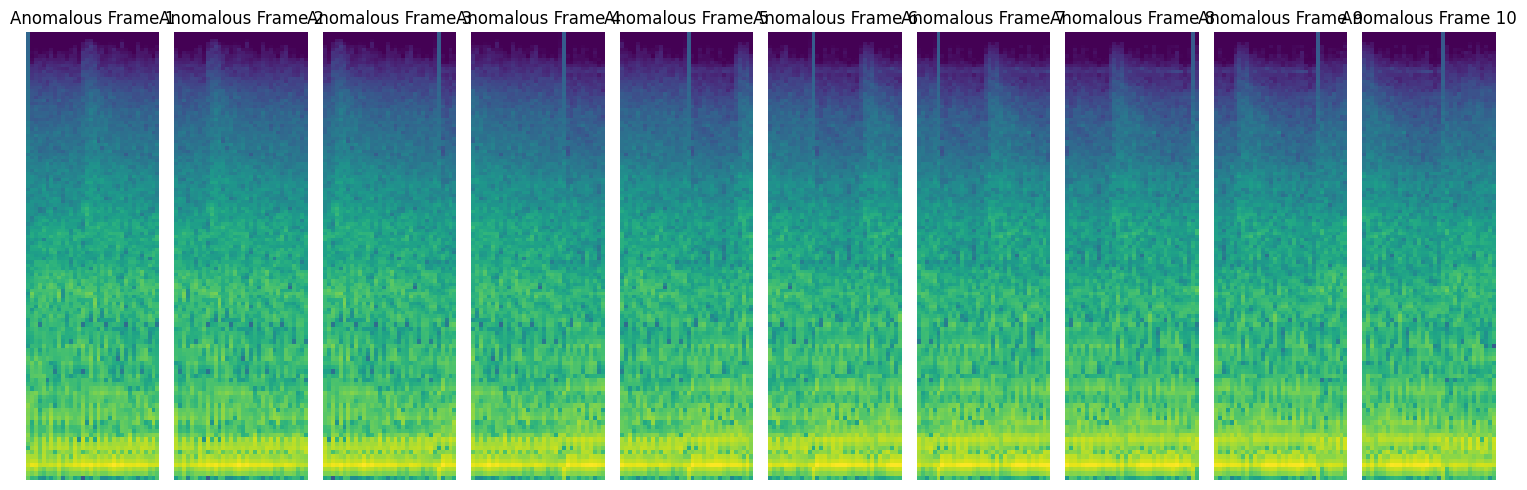

Visualizing frames for normal sounds...


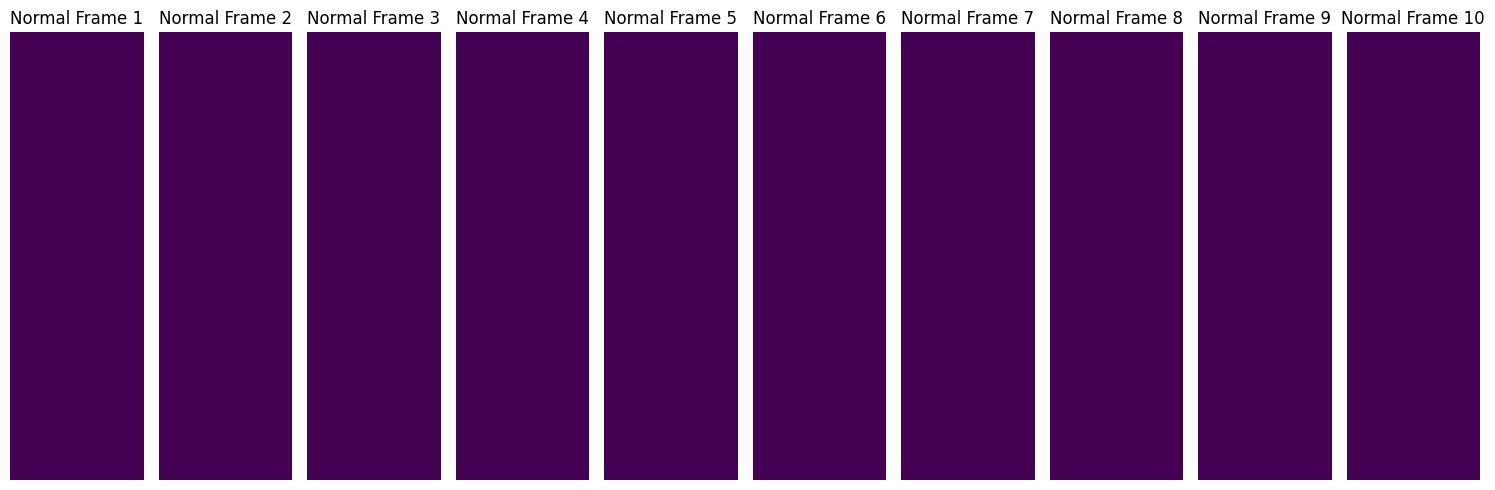

In [11]:
# Visualize frames
print("Visualizing frames for anomalous sounds...")
plot_frames(anomalous_frames, num_frames=10, title_prefix="Anomalous Frame")

print("Visualizing frames for normal sounds...")
plot_frames(normal_frames, num_frames=10, title_prefix="Normal Frame")

In [12]:
# Save frames
np.save(output_anomalous_frames_path, anomalous_frames)
np.save(output_normal_frames_path, normal_frames)

## 3 Train and Test Splits

In [13]:
# Load frames
anomalous_frames = np.load(output_anomalous_frames_path)
normal_frames = np.load(output_normal_frames_path)

In [14]:
# Get the number of Mel bands and frame size for reshaping later
num_mels = anomalous_frames.shape[1]

In [15]:
# Split normal frames into training and test sets
normal_train, normal_test = train_test_split(normal_frames, test_size=0.15, random_state=42)

In [16]:
# Split anomalous frames into training and test sets
anomalous_train, anomalous_test = train_test_split(anomalous_frames, test_size=0.50, random_state=42)

In [17]:
# Combine normal_train and part of anomalous_train for training
train_frames = np.concatenate([normal_train, anomalous_train], axis=0)
train_labels = np.concatenate([np.zeros(len(normal_train)), np.ones(len(anomalous_train))])  # 0 for normal, 1 for anomalous

In [18]:
# Combine normal_test and remaining anomalous_frames for testing
test_frames = np.concatenate([normal_test, anomalous_test], axis=0)
test_labels = np.concatenate([np.zeros(len(normal_test)), np.ones(len(anomalous_test))])  # 0 for normal, 1 for anomalous

In [19]:
# Shuffle the training set
train_indices = np.arange(len(train_frames))
np.random.shuffle(train_indices)
train_frames = train_frames[train_indices]
train_labels = train_labels[train_indices]

In [20]:
# Shuffle the test set
test_indices = np.arange(len(test_frames))
np.random.shuffle(test_indices)
test_frames = test_frames[test_indices]
test_labels = test_labels[test_indices]

In [21]:
# Save datasets
np.save(train_frames_path, train_frames)
np.save("train_labels.npy", train_labels)
np.save(test_frames_path, test_frames)
np.save(test_labels_path, test_labels)

In [22]:
# Load datasets
X_train = np.load(train_frames_path)
y_train = np.load("train_labels.npy")
X_test = np.load(test_frames_path)
y_test = np.load(test_labels_path)

In [23]:
# Flatten the frames for model input
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

In [24]:
# Adjust labels: 1 for normal, -1 for anomalous
y_train_adjusted = np.where(y_train == 0, 1, -1)
y_test_adjusted = np.where(y_test == 0, 1, -1)

## 4 LOF Implementation

In [25]:
# Define the classify_anomalies function with anomalies in training
def classify_anomalies_with_anomalies_in_training(train_data, train_labels, test_data, test_labels, machine, feat_label):
    scaler = MinMaxScaler(feature_range=(-5, 5))
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    
    # LOF without PCA
    lof = LocalOutlierFactor(novelty=False, contamination=0.1)
    lof.fit(train_data)
    train_pred = lof.fit_predict(train_data)
    test_pred = lof.fit_predict(test_data)  # Note: LOF with novelty=False cannot predict on new data properly
    
    # Since LOF with novelty=False is not designed for new data, we might need to train on combined data
    # For comparison, we'll use Isolation Forest, which can handle anomalies in training data
    
    # Isolation Forest with anomalies in training
    isolation_forest = IsolationForest(contamination=0.1, random_state=42)
    isolation_forest.fit(train_data)
    predictions = isolation_forest.predict(test_data)
    
    # Adjust predictions: 1 for normal, -1 for anomalies
    predictions = np.where(predictions == 1, 1, -1)
    
    # Evaluate performance
    auc = roc_auc_score(test_labels, isolation_forest.decision_function(test_data))
    recall = recall_score(test_labels, predictions, pos_label=-1)
    precision = precision_score(test_labels, predictions, pos_label=-1)
    abf1 = f1_score(test_labels, predictions, pos_label=-1)
    conf_matrix = confusion_matrix(test_labels, predictions)
    fpr, tpr, thresholds = roc_curve(test_labels, isolation_forest.decision_function(test_data))
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for Isolation Forest')
    plt.legend(loc='lower right')
    plt.show()
    
    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomalous'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Isolation Forest')
    plt.show()
    
    # Prepare results
    results_df = pd.DataFrame({
        "Machine": [machine],
        "Features": [feat_label],
        "Model": ["Isolation Forest with Anomalies in Training"],
        "AUC": [auc],
        "Recall": [recall],
        "Precision": [precision],
        "Abnormal (-1) F1": [abf1],
    })
    
    print(results_df)
    
    return predictions, isolation_forest.decision_function(test_data)

## 5 LOF Classification (Training & Testing)

c:\Users\s.krummenacher\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\s.krummenacher\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


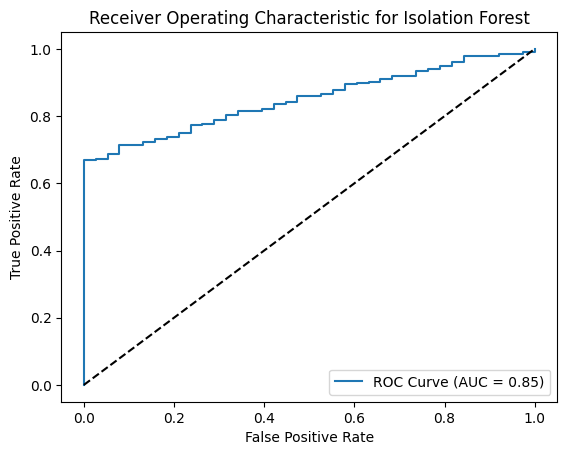

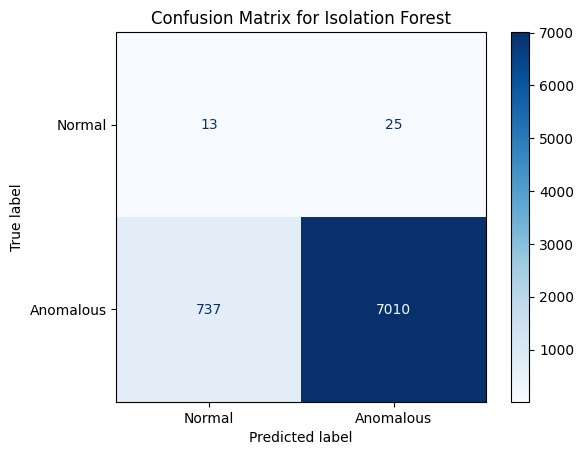

              Machine                Features  \
0  Hydropower Machine  Mel-Spectrogram Frames   

                                         Model       AUC    Recall  Precision  \
0  Isolation Forest with Anomalies in Training  0.849025  0.342105   0.017333   

   Abnormal (-1) F1  
0          0.032995  


In [26]:
predictions, scores = classify_anomalies_with_anomalies_in_training(
    X_train_flat, y_train_adjusted, X_test_flat, y_test_adjusted, "Hydropower Machine", "Mel-Spectrogram Frames"
)


In [ ]:
# Select the best model based on AUC
best_model_index = np.argmax(results_df['AUC'])
best_model_name = results_df['Model'][best_model_index]
print(f"Best model based on AUC: {best_model_name}")

In [ ]:
# Get the results for the best model
best_model_results = model_results[best_model_index]

In [ ]:
predictions = best_model_results['predictions']
scores = best_model_results['scores']
conf_matrix = best_model_results['conf_matrix']
roc_auc = best_model_results['roc_auc']
fpr = best_model_results['fpr']
tpr = best_model_results['tpr']
thresholds = best_model_results['thresholds']

In [ ]:
# Reshape test_frames back to original shape for plotting
frame_size = X_test_flat.shape[1] // num_mels
test_frames_reshaped = X_test_flat.reshape(-1, num_mels, frame_size)

In [ ]:
# Identify indices
correctly_classified_anomalies = np.where((y_test_adjusted == -1) & (predictions == -1))[0]
wrongly_classified_anomalies = np.where((y_test_adjusted == -1) & (predictions == 1))[0]
wrongly_classified_normals = np.where((y_test_adjusted == 1) & (predictions == -1))[0]

In [ ]:
# Select up to 5 samples from each category
num_samples = 5
correct_anomaly_indices = correctly_classified_anomalies[:num_samples]
wrong_anomaly_indices = wrongly_classified_anomalies[:num_samples]
wrong_normal_indices = wrongly_classified_normals[:num_samples]

In [ ]:
# Function to plot specified frames
def plot_specified_frames(frames, indices, title_prefix="Frame"):
    num_frames = len(indices)
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    for i, idx in enumerate(indices):
        ax = axes[i] if num_frames > 1 else axes
        img = librosa.display.specshow(frames[idx], x_axis=None, y_axis="mel", cmap="viridis", ax=ax)
        ax.set_title(f"{title_prefix} {i+1}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
# Plot frames
print("Correctly Classified Anomalies:")
if len(correct_anomaly_indices) > 0:
    plot_specified_frames(test_frames_reshaped, correct_anomaly_indices, title_prefix="Correct Anomaly")
else:
    print("No correctly classified anomalies.")

print("Wrongly Classified Anomalies:")
if len(wrong_anomaly_indices) > 0:
    plot_specified_frames(test_frames_reshaped, wrong_anomaly_indices, title_prefix="Wrongly Classified Anomaly")
else:
    print("No wrongly classified anomalies.")

print("Wrongly Classified Normal Frames:")
if len(wrong_normal_indices) > 0:
    plot_specified_frames(test_frames_reshaped, wrong_normal_indices, title_prefix="Wrongly Classified Normal")
else:
    print("No wrongly classified normal frames.")

In [ ]:
# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomalous'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

In [ ]:
# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for {best_model_name}')
plt.legend(loc='lower right')
plt.show()

c:\Users\s.krummenacher\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\s.krummenacher\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Mel-Spectrogram Frames features were reduced to 1396 components for LOF
Mel-Spectrogram Frames features were reduced to 1396 components for Isolation Forest


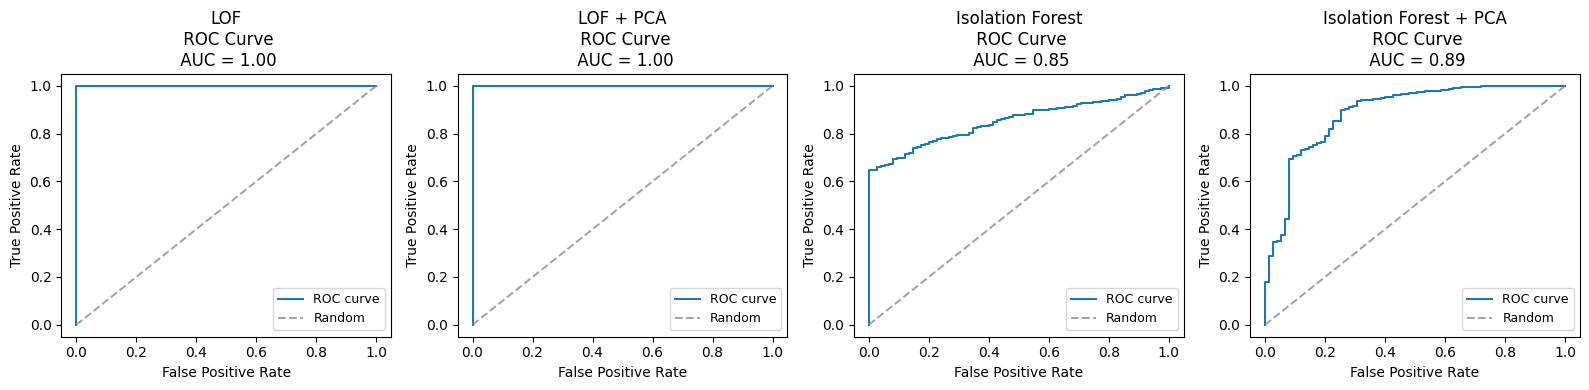

              Machine                Features                   Model  \
0  Hydropower Machine  Mel-Spectrogram Frames                     LOF   
1  Hydropower Machine  Mel-Spectrogram Frames               LOF + PCA   
2  Hydropower Machine  Mel-Spectrogram Frames        Isolation Forest   
3  Hydropower Machine  Mel-Spectrogram Frames  Isolation Forest + PCA   

        AUC  Recall  Precision  Abnormal (-1) F1  
0  0.999305     1.0   0.011263          0.022275  
1  0.999444     1.0   0.011263          0.022275  
2  0.851851     1.0   0.011263          0.022275  
3  0.887741     1.0   0.011263          0.022275  
Best model based on AUC: LOF + PCA
Correctly Classified Anomalies:


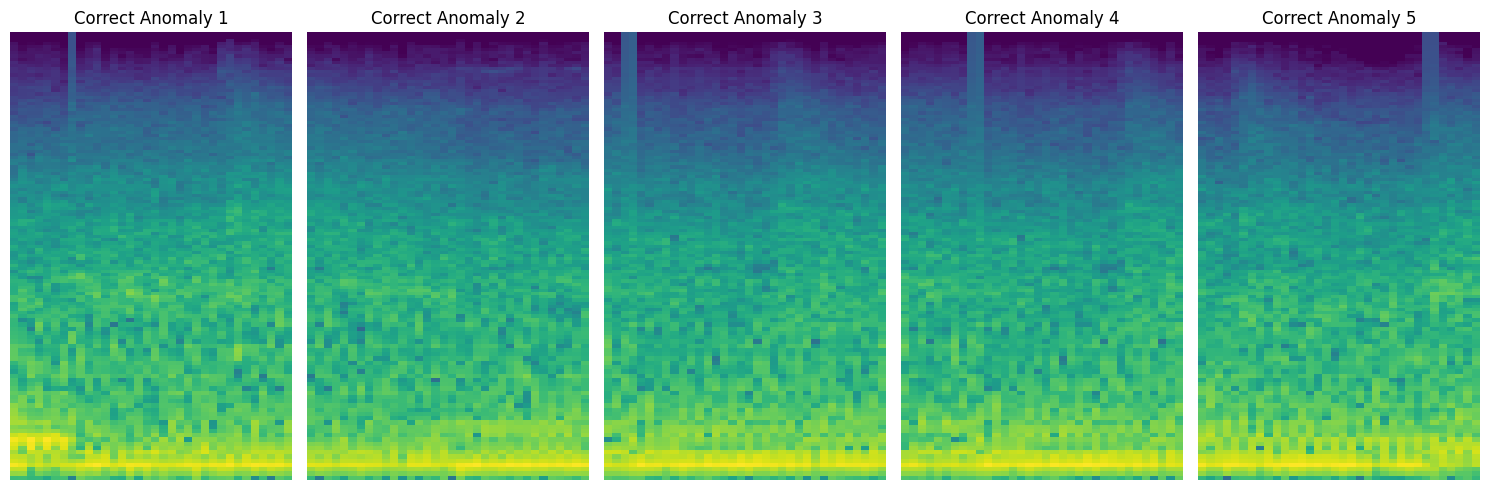

Wrongly Classified Anomalies:
No wrongly classified anomalies.
Wrongly Classified Normal Frames:


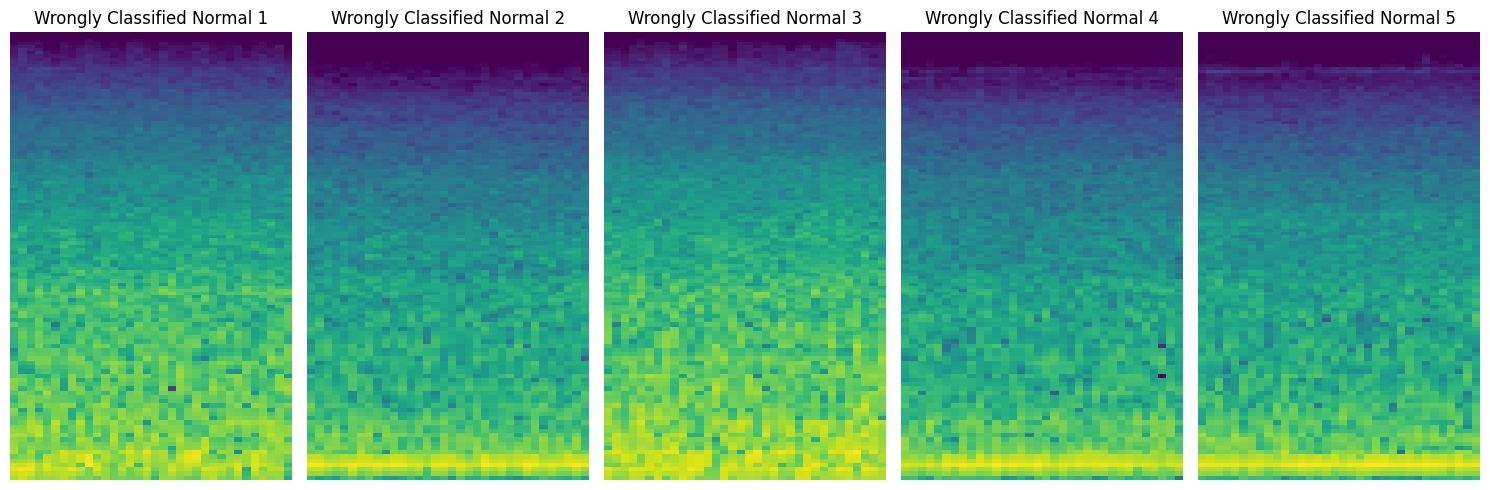

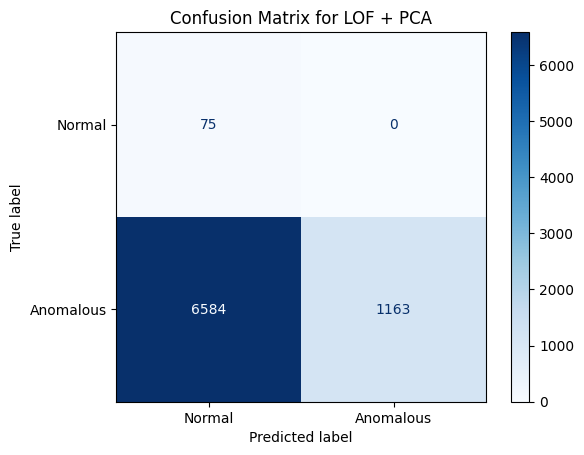

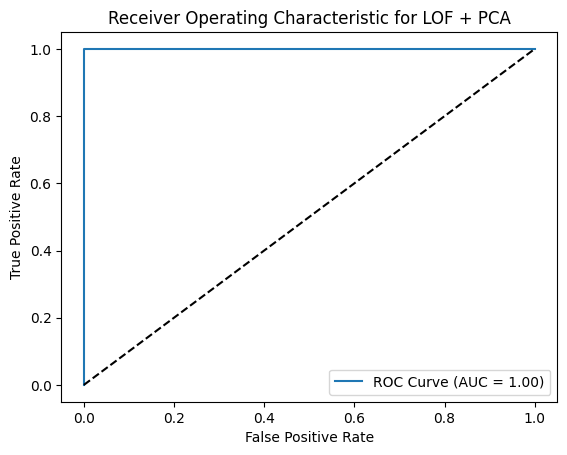